In [3]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [4]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        self.output = input
        return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        self.gradInput = gradOutput
        return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [5]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.layer_inputs = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.output = input
        self.layer_inputs = [input]  # Сохраняем входы для каждого слоя
        for module in self.modules:
            self.output = module.forward(self.output)
            self.layer_inputs.append(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        self.gradInput = gradOutput
        # Обратный проход через слои в обратном порядке
        for i, module in enumerate(reversed(self.modules)):
            # Получаем вход, который был использован в прямом проходе для текущего модуля
            module_input = self.layer_inputs[-(i + 2)]  # -2, так как layer_inputs содержит входы до и после каждого слоя
            current_gradOutput = self.gradInput
            self.gradInput = module.backward(module_input, current_gradOutput)
            module.accGradParameters(module_input, current_gradOutput)
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

In [6]:
# import torch
# def test_Sequential_SimpleGradCheck():
#     np.random.seed(42)
#     torch.manual_seed(42)

#     # Создаем простую модель: только ChannelwiseScaling
#     n_in = 3
#     custom_model = Sequential()
#     scaling_layer = ChannelwiseScaling(n_in)
#     custom_model.add(scaling_layer)

#     # Инициализируем параметры как в PyTorch
#     torch_layer = torch.nn.Linear(n_in, n_in, bias=True)
#     scaling_layer.gamma = torch_layer.weight.data.numpy().copy()
#     scaling_layer.beta = torch_layer.bias.data.numpy().copy()

#     # Тестовые данные
#     input_data = np.array([[1.0, 2.0, 3.0]], dtype=np.float32)
#     grad_output = np.array([[0.1, 0.2, 0.3]], dtype=np.float32)

#     # Forward pass
#     custom_output = custom_model.updateOutput(input_data)

#     # Backward pass
#     custom_model.zeroGradParameters()
#     custom_grad = custom_model.backward(input_data, grad_output)

#     # Получаем градиенты параметров
#     weight_grad, bias_grad = custom_model.getGradParameters()

#     # PyTorch расчет
#     torch_input = torch.tensor(input_data, requires_grad=True)
#     torch_output = torch_layer(torch_input)
#     torch_output.backward(torch.tensor(grad_output))

#     # Проверка градиентов
#     assert np.allclose(torch_layer.weight.grad.numpy(), weight_grad, atol=1e-6), \
#         f"Ошибка в градиенте gamma: {torch_layer.weight.grad.numpy()} vs {weight_grad}"

#     assert np.allclose(torch_layer.bias.grad.numpy(), bias_grad, atol=1e-6), \
#         f"Ошибка в градиенте beta: {torch_layer.bias.grad.numpy()} vs {bias_grad}"

#     print("Тест пройден!")

# # Запуск теста
# test_Sequential_SimpleGradCheck()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [7]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW += gradOutput.T @ input
        self.gradb += gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [8]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        input_shifted = input - input.max(axis=1, keepdims=True)
        exp = np.exp(input_shifted)
        self.output = exp / exp.sum(axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(input, dtype=np.float64)
        batch_size = input.shape[0]

        for i in range(batch_size):
          s = self.output[i].reshape(-1, 1)
          jacobian = np.diagflat(s) - np.outer(s, s)
          self.gradInput[i] = (gradOutput[i] @ jacobian).reshape(-1)
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [9]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        input_shifted = input - input.max(axis=1, keepdims=True)
        log_sum = np.log(np.exp(input_shifted).sum(axis=1, keepdims=True))
        self.output = input_shifted - log_sum
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        softmax = np.exp(self.output)
        self.gradInput = gradOutput - softmax * gradOutput.sum(axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [10]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        self.batch_mean = None
        self.batch_var = None
        self.x_centered = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            self.batch_mean = input.mean(axis=0)
            self.batch_var = input.var(axis=0, ddof=0) + self.EPS
            self.x_centered = input - self.batch_mean
            self.output = self.x_centered / np.sqrt(self.batch_var)
            # Обновление скользящих средних
            if self.moving_mean is None:
                self.moving_mean = self.batch_mean.copy()
                self.moving_variance = self.batch_var.copy()
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.batch_mean
                self.moving_variance = self.alpha * (self.moving_variance + self.EPS) + (1 - self.alpha) * self.batch_var
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if not self.training:
            # В режиме инференса градиент простой
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
            return self.gradInput

        # Размер батча и количество признаков
        N = input.shape[0]

        # Градиенты через цепное правило
        std_inv = 1.0 / np.sqrt(self.batch_var)

        # 1. Градиент по нормализованным данным
        dldx_hat = gradOutput * std_inv

        # 2. Градиент по дисперсии
        dldvar = np.sum(gradOutput * self.x_centered * (-0.5) * (self.batch_var ** (-1.5)), axis=0)

        # 3. Градиент по среднему
        dldmean = np.sum(gradOutput * (-std_inv), axis=0) + dldvar * (-2.0 / N) * np.sum(self.x_centered, axis=0)

        # Итоговый градиент
        self.gradInput = (dldx_hat +
                         (2.0 / N) * dldvar * self.x_centered +
                         (1.0 / N) * dldmean)

        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [11]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out).astype(np.float32)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out).astype(np.float32)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [12]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p) / (1 - self.p)
            self.output = input * self.mask
        else:
            self.output = input
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * self.mask if self.training else gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

## 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [13]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.padding_mode = padding_mode

        kH, kW = self.kernel_size
        self.weight = np.random.randn(out_channels, in_channels, kH, kW).astype(np.float32)
        if self.bias:
            self.bias = np.random.randn(out_channels).astype(np.float32)
        else:
            self.bias = None

    def updateOutput(self, input):
        # Your code goes here. ################################################

        pad = self.padding
        padded_input = np.pad(input,
                              pad_width=((0,0), (0,0), (pad, pad), (pad, pad)),
                              mode='constant')

        N, C, H_pad, W_pad = padded_input.shape
        kH, kW = self.kernel_size
        stride = self.stride

        H_out = (H_pad - kH) // stride + 1
        W_out = (W_pad - kW) // stride + 1

        shape = (N, C, H_out, W_out, kH, kW)
        strides = (padded_input.strides[0],
                   padded_input.strides[1],
                   stride * padded_input.strides[2],
                   stride * padded_input.strides[3],
                   padded_input.strides[2],
                   padded_input.strides[3])
        strided = np.lib.stride_tricks.as_strided(padded_input,
                                                  shape=shape,
                                                  strides=strides,
                                                  writeable=False)

        cols = strided.transpose(0, 2, 3, 1, 4, 5).reshape(-1, C * kH * kW).T

        weight_matrix = self.weight.reshape(self.out_channels, -1)
        output_flat = weight_matrix @ cols

        output = output_flat.reshape(self.out_channels, N, H_out, W_out).transpose(1, 0, 2, 3)

        if self.bias is not None:
            output += self.bias.reshape(1, -1, 1, 1)

        self.output = output

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        N, C, H, W = input.shape
        pad = self.padding
        kH, kW = self.kernel_size
        stride = self.stride

        H_pad = H + 2 * pad
        W_pad = W + 2 * pad
        H_out = (H_pad - kH) // stride + 1
        W_out = (W_pad - kW) // stride + 1

        gradOutput_reshaped = gradOutput.transpose(1, 0, 2, 3).reshape(self.out_channels, -1)

        W_flat = self.weight.reshape(self.out_channels, -1)
        dX_col = W_flat.T @ gradOutput_reshaped

        padded_grad = np.zeros((N, C, H_pad, W_pad), dtype=input.dtype)

        i_indices = np.arange(N * H_out * W_out)
        n = i_indices // (H_out * W_out)
        rest = i_indices % (H_out * W_out)
        h_out = rest // W_out
        w_out = rest % W_out

        h_start = h_out * stride
        w_start = w_out * stride

        rows = np.arange(C * kH * kW)
        c, kh, kw = np.unravel_index(rows, (C, kH, kW))

        n_full = np.repeat(n, C*kH*kW)
        c_full = np.tile(c, N * H_out * W_out)
        h_full = np.repeat(h_start, C*kH*kW) + np.tile(kh, N * H_out * W_out)
        w_full = np.repeat(w_start, C*kH*kW) + np.tile(kw, N * H_out * W_out)

        h_full = np.clip(h_full, 0, H_pad - 1)
        w_full = np.clip(w_full, 0, W_pad - 1)

        dX_flat = dX_col.T.ravel()
        np.add.at(padded_grad, (n_full, c_full, h_full, w_full), dX_flat)

        self.gradInput = padded_grad[:, :, pad:H_pad - pad, pad:W_pad - pad]
        return self.gradInput

    def __repr__(self):
        return "Conv2d"

## 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [14]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)


    def updateOutput(self, input):
        # Your code goes here. ################################################
        padH, padW = self.padding
        kH, kW = self.kernel_size
        sH, sW = self.stride

        # Применяем padding к входу
        padded_input = np.pad(input, ((0,0), (0,0), (padH, padH), (padW, padW)), mode='constant')
        N, C, H_padded, W_padded = padded_input.shape

        # Вычисляем размеры выхода
        out_h = (H_padded - kH) // sH + 1
        out_w = (W_padded - kW) // sW + 1

        # Создаем окна с использованием as_strided
        strides = padded_input.strides
        new_strides = (strides[0], strides[1], sH * strides[2], sW * strides[3], strides[2], strides[3])
        windows = np.lib.stride_tricks.as_strided(padded_input, shape=(N, C, out_h, out_w, kH, kW), strides=new_strides)

        # Находим максимумы и их индексы
        windows_flat = windows.reshape(N, C, out_h, out_w, -1)
        self.output = np.max(windows_flat, axis=-1)
        max_indices = np.argmax(windows_flat, axis=-1)

        # Сохраняем индексы для обратного прохода
        self.h_idx = max_indices // kW
        self.w_idx = max_indices % kW
        self.input_shape = input.shape

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if not hasattr(self, 'h_idx') or not hasattr(self, 'w_idx'):
            raise RuntimeError("Сначала выполните forward pass")

        padH, padW = self.padding
        kH, kW = self.kernel_size
        sH, sW = self.stride
        N, C, out_h, out_w = gradOutput.shape
        H_padded = self.input_shape[2] + 2 * padH
        W_padded = self.input_shape[3] + 2 * padW

        # Создаем массив для накопления градиентов с учетом padding
        gradInput_padded = np.zeros((N, C, H_padded, W_padded), dtype=input.dtype)

        # Вычисляем начальные позиции окон
        i = np.arange(out_h) * sH
        j = np.arange(out_w) * sW

        # Формируем индексы для всех элементов
        h_start = i.reshape(1, 1, out_h, 1)
        w_start = j.reshape(1, 1, 1, out_w)

        # Вычисляем позиции максимумов в padded_input
        h_padded = h_start + self.h_idx
        w_padded = w_start + self.w_idx

        # Преобразуем все индексы в плоские массивы
        n_indices = np.broadcast_to(np.arange(N)[:, None, None, None], (N, C, out_h, out_w)).flatten()
        c_indices = np.broadcast_to(np.arange(C)[None, :, None, None], (N, C, out_h, out_w)).flatten()
        h_flat = h_padded.flatten()
        w_flat = w_padded.flatten()
        grad_flat = gradOutput.flatten()

        # Накопление градиентов с помощью np.add.at
        np.add.at(gradInput_padded, (n_indices, c_indices, h_flat, w_flat), grad_flat)

        # Удаляем padding
        self.gradInput = gradInput_padded[:, :, padH:H_padded-padH, padW:W_padded-padW]

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        kh, kw = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size
        sh, sw = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride
        ph, pw = (self.padding, self.padding) if isinstance(self.padding, int) else self.padding

        # Применение паддинга
        padded_input = np.pad(input, ((0, 0), (0, 0), (ph, ph), (pw, pw)), mode='constant')

        N, C, H_pad, W_pad = padded_input.shape
        out_h = (H_pad - kh) // sh + 1
        out_w = (W_pad - kw) // sw + 1

        # Создание окон через as_strided
        new_shape = (N, C, out_h, out_w, kh, kw)
        batch_stride, channel_stride, h_stride, w_stride = padded_input.strides
        new_strides = (
            batch_stride,
            channel_stride,
            sh * h_stride,
            sw * w_stride,
            h_stride,
            w_stride
        )
        windows = np.lib.stride_tricks.as_strided(padded_input, new_shape, new_strides)

        # Усреднение по окну
        self.output = np.mean(windows, axis=(4, 5))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        kh, kw = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size
        sh, sw = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride
        ph, pw = (self.padding, self.padding) if isinstance(self.padding, int) else self.padding

        N, C, H_in, W_in = input.shape
        H_pad = H_in + 2 * ph
        W_pad = W_in + 2 * pw

        # Инициализация grad_padded
        grad_padded = np.zeros((N, C, H_pad, W_pad), dtype=input.dtype)
        scale = 1.0 / (kh * kw)

        # Ручное распределение градиентов по окнам
        for n in range(N):
            for c in range(C):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * sh
                        h_end = h_start + kh
                        w_start = j * sw
                        w_end = w_start + kw
                        grad_padded[n, c, h_start:h_end, w_start:w_end] += gradOutput[n, c, i, j] * scale

        # Обрезка паддинга
        self.gradInput = grad_padded[:, :, ph:ph+H_in, pw:pw+W_in]

        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

## 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [15]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        input_size = input.shape
        ndim = input.ndim

        # Преобразование отрицательных индексов
        end_dim = self.end_dim if self.end_dim >= 0 else ndim + self.end_dim
        start_dim = self.start_dim if self.start_dim >= 0 else ndim + self.start_dim

        # Проверка валидности индексов
        if start_dim < 0 or start_dim >= ndim:
            raise ValueError(f"start_dim {self.start_dim} is out of range for input with {ndim} dimensions")
        if end_dim < 0 or end_dim >= ndim:
            raise ValueError(f"end_dim {self.end_dim} is out of range for input with {ndim} dimensions")
        if start_dim > end_dim:
            raise ValueError(f"start_dim ({start_dim}) must be <= end_dim ({end_dim})")

        # Вычисление новой формы
        new_shape = list(input_size[:start_dim])
        flattened_size = 1
        for i in range(start_dim, end_dim + 1):
            flattened_size *= input_size[i]
        new_shape.append(flattened_size)
        new_shape += list(input_size[end_dim + 1:])

        self.output = input.reshape(new_shape)
        self.input_shape = input_size  # Сохраняем форму для обратного прохода
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.input_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [16]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [17]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * np.where(input > 0, 1.0, self.slope)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [18]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * np.where(input > 0, 1, self.alpha * np.exp(input))
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [19]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        max_input = np.maximum(input, 0)
        exp_term = np.exp(-np.abs(input))
        self.output = max_input + np.log1p(exp_term)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        sigmoid = np.zeros_like(input)
        mask = (input >= 0)

        sigmoid[mask] = 1.0 / (1.0 + np.exp(-input[mask]))

        sigmoid[~mask] = np.exp(input[~mask]) / (1.0 + np.exp(input[~mask]))
        self.gradInput = gradOutput * sigmoid
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

## 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [20]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def scalar_erf(self, x, n=1000):
      if x == 0:
        return 0.0

      sign = 1 if x > 0 else -1
      x = abs(x)

      t = np.linspace(0, x, n + 1)
      f = np.exp(-t**2)
      h = x / n

      integral = h/3 * (f[0] + 4*np.sum(f[1:-1:2]) + 2*np.sum(f[2:-2:2]) + f[-1])
      return sign * 2/np.sqrt(np.pi) * integral


    def erf(self, arr, n=1000):
      erf_vectorized = np.vectorize(self.scalar_erf, excluded=['n'])
      return erf_vectorized(arr, n=n)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input * 0.5 * (1 + self.erf(input / np.sqrt(2)))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        phi = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (input ** 2))
        cdf = 0.5 * (1 + self.erf(input / np.sqrt(2)))
        der = cdf + input * phi
        self.gradInput = gradOutput * der
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [21]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [22]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target, 2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [23]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        selected_probs = np.sum(input_clamp * target, axis=1)
        self.output = -np.sum(np.log(selected_probs)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = (-target / input_clamp) / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [24]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = - (input * target).sum() / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = - target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

# Пункт 1.

In [25]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params["params"])  # Параметры модели (например, веса и смещения)
        self.grads = list(params["grads"])
        self.lr = lr               # Скорость обучения
        self.beta1 = beta1         # Коэффициент для первого момента
        self.beta2 = beta2         # Коэффициент для второго момента
        self.epsilon = epsilon     # Малое число для стабильности

        # Инициализация моментов
        self.m = [np.zeros_like(p) for p in self.params]
        self.v = [np.zeros_like(p) for p in self.params]
        self.t = 0                 # Счетчик шагов

    def step(self):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.params, self.grads)):
            # Обновление моментов
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            # Коррекция смещения
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Обновление параметра
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    # def get_gradients(self):
    #   return [param.grad for param in self.params]

    def zero_grad(self, params):
        # Для совместимости с PyTorch-подобным API (в этой реализации не используется)
        for param in self.params:
            param.grad.fill(0)
        pass

# Пункт 2.

In [26]:
# Параметры датасета
n_samples = 10000   # Количество образцов
n_features = 5     # Количество признаков
n_outputs = 3      # Количество целевых переменных
noise_scale = 0.2  # Уровень шума

# Генерация признаков (X)
np.random.seed(42)
X = np.random.randn(n_samples, n_features)

# Генерация истинных коэффициентов (весов) для каждого выхода
true_weights = np.random.randn(n_features, n_outputs) * 2  # Матрица [n_features x n_outputs]
true_bias = np.random.randn(n_outputs)                     # Вектор смещений [n_outputs]

# Генерация целевых переменных (y) с шумом
y_true = X @ true_weights + true_bias  # Линейная комбинация
y = y_true + np.random.randn(n_samples, n_outputs) * noise_scale  # Шум для каждого выхода



# Проверка размерностей
print("X shape:", X.shape)  # (1000, 5)
print("y shape:", y.shape)  # (1000, 3)

X shape: (10000, 5)
y shape: (10000, 3)


In [27]:
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=None):
    """
    Параметры:
    - X: Массив признаков (n_samples, n_features).
    - y: Массив целевых значений (n_samples,).
    - test_size: Доля тестовой выборки (по умолчанию 0.2).
    - random_state: Seed для воспроизводимости.
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Перемешивание индексов

    test_samples = int(n_samples * test_size)
    val_samples = int(n_samples * val_size)
    train_samples = n_samples - test_samples - val_samples

    X_train = X[indices[:train_samples]]
    X_val = X[indices[train_samples : train_samples + val_samples]]
    X_test = X[indices[train_samples + val_samples :]]

    y_train = y[indices[:train_samples]]
    y_val = y[indices[train_samples : train_samples + val_samples]]
    y_test = y[indices[train_samples + val_samples :]]

    return X_train, X_test, X_val, y_val, y_train, y_test

In [28]:
X_train, X_test, X_val, y_val, y_train, y_test = train_val_test_split(X, y, 0.2, 0.2, random_state=30)

In [29]:
model = Sequential()
model.add(Linear(5, 20))
model.add(Linear(20, 64))
model.add(BatchNormalization(64))
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Linear(64, 20))
model.add(BatchNormalization(20))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Linear(20, 3))

In [30]:
loss = MSECriterion()

parameters = []
grads = []
for module in model.modules:
    if isinstance(module, Linear):
        parameters.extend(module.getParameters())  # W и b как отдельные параметры
        grads.extend(module.getGradParameters())

all_parameters = {"params": parameters, "grads": grads}

optimizer = Adam(all_parameters, lr=0.001)

In [31]:
def train_model(model, loss_function, optimizer, X_train, y_train, X_val, y_val, epochs=5, batch_size=32):

    train_losses, val_losses = [], []
    train_mse, val_mse = [], []

    # training
    for epoch in range(epochs):
      running_loss, running_mse = 0, 0

      for i in range(0, X_train.shape[0], batch_size):
          X_batch = X_train[i:i+batch_size]
          y_batch = y_train[i:i+batch_size]

          # Прямое распространение
          output = model.updateOutput(X_batch)
          loss_score = loss_function.updateOutput(output, y_batch)
          running_loss += loss_score * batch_size
          running_mse += loss_function.updateOutput(output, y_batch) #?

          # Обратное распространение
          gradOutput = loss_function.updateGradInput(output, y_batch)
          model.zeroGradParameters()
          model.backward(X_batch, gradOutput)

          # Обновление параметров через Adam
          optimizer.step()

      train_losses.append(running_loss/X_train.shape[0])
      train_mse.append(running_mse)

      running_val_loss = 0
      running_val_mse = 0
      # validation
      for i in range(0, len(X_val), batch_size):
          output = model.updateOutput(X_val[i:i+batch_size])
          running_val_loss += loss_function.updateOutput(output, y_val[i:i+batch_size]) * batch_size
          running_val_mse += loss_function.updateOutput(output, y_val[i:i+batch_size])

      val_losses.append(running_val_loss/X_val.shape[0])
      val_mse.append(running_val_mse)

    return (train_mse, val_mse), (train_losses, val_losses)

In [32]:
history = train_model(model, loss, optimizer, X_train, y_train, X_val, y_val, 10, 16)

<ipython-input-10-98778572745a>:25: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.batch_mean
<ipython-input-10-98778572745a>:26: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * (self.moving_variance + self.EPS) + (1 - self.alpha) * self.batch_var


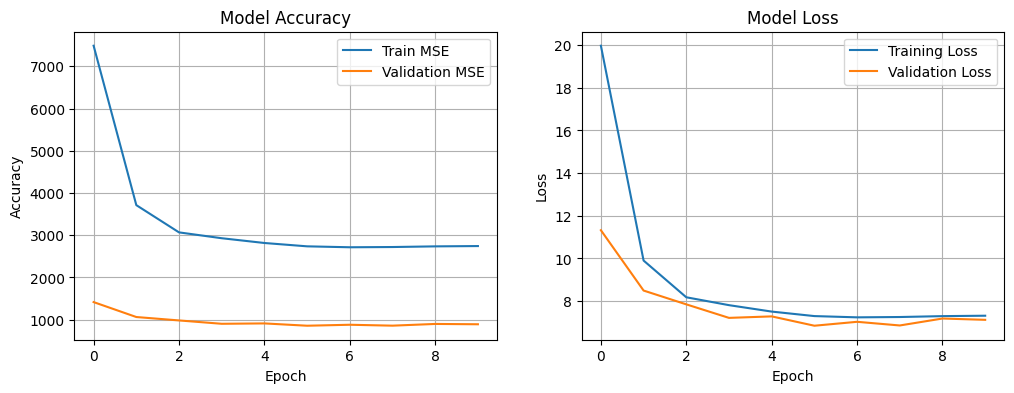

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# График точности
plt.subplot(1,2,1)
plt.plot(history[0][0], label='Train MSE')
plt.plot(history[0][1], label='Validation MSE')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1,2,2)
plt.plot(history[1][0], label='Training Loss')
plt.plot(history[1][1], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [34]:
# Оценка модели на тестовом наборе
def test_model(model, loss_function, X_test, y_test, batch_size=32):
  test_loss = 0.0
  test_mse = 0.0

  for i in range(0, len(X_test), batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]

        output = model.updateOutput(X_batch)
        batch_mse = loss_function.updateOutput(output, y_batch)
        test_loss += batch_mse * len(X_batch)
        test_mse += batch_mse


  print(f'Test Loss: {test_loss / X_test.shape[0]:.4f}')
  print(f'Test MSE: {test_mse:.4f}')

In [35]:
test_model(model, loss, X_test, y_test, 16)

Test Loss: 6.6649
Test MSE: 833.1126


# Пункт 3